In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(50, 4, 4)


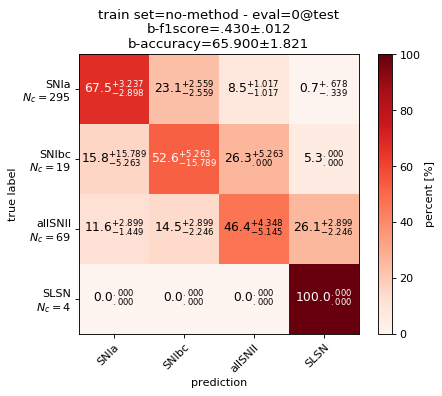

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_id
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.statistics import XError

method = 'linear-fstw'
kf = 0
eval_lcset_name = 'test' # val test
train_config = 'r'

rootdir = f'../save/exp=rf_eval°train_config={train_config}/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method={method}/{kf}@{eval_lcset_name}'
results = gather_files_by_id(rootdir)
class_names = results[0]['lcset_info']['class_names']
cms = np.concatenate([r['cm'][None] for r in results], axis=0)
f1score_xe = XError([r['metrics_dict']['b-f1score'] for r in results])
accuracy_xe = XError([r['metrics_dict']['b-accuracy'] for r in results])
#lcdataset = load_pickle(filedir)
print(cms.shape)

### plot cm
title = ''
title += f'train set={"no-method" if train_config=="r" else method} - eval={kf}@{eval_lcset_name}'+'\n'
title += f'b-f1score={f1score_xe}'+'\n'
title += f'b-accuracy={accuracy_xe}'+'\n'
cm_kwargs = {
    'title':title[:-1],
    'figsize':(6,5),
    'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
}
fig, ax = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
plt.show()

In [ ]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

In [ ]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir

filedir = f'../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['__rootdir']
cfilename = filedict['__cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_
from lcfats.classifiers import train_classifiers
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError
import matplotlib.pyplot as plt

kf = 0
max_model_ids = 50
test_lcset_name = 'test' # val test
methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw', 'spm-mcmc-fstw', 'spm-mle-estw', 'spm-mcmc-estw']
#methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw']
#methods = ['linear-fstw']
methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['bspline-fstw']
methods = ['spm-mcmc-estw']

for method in methods:
    new_cfilename = f'{cfilename}°method={method}'
    filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
    lcdataset = load_pickle(filedir)
    #print(lcdataset);assert 0
    train_configs = [
        'r',
        's',
        'r+s',
        #'r-s',
    ]
    for train_config in train_configs:
        load_rootdir = f'../save/{survey}/{new_cfilename}'
        fit_kwargs = {
            'max_model_ids':max_model_ids,
            'kf':kf,
        }
        train_lcset_name = f'{method} [{train_config}]'
        results_dict, model_ids = train_classifiers(lcdataset, method, train_config, test_lcset_name, load_rootdir, **fit_kwargs)
        
        if not train_config=='r-s':
            ### plot cms
            d = results_dict
            lcset_name = d[model_ids[0]]['test_lcset_name']
            class_names = d[model_ids[0]]['class_names']
            cms = [d[id]['cm'][None] for id in model_ids]
            f1score_xe = XError([d[id]['metrics_dict']['b-f1score'] for id in model_ids])
            accuracy_xe = XError([d[id]['metrics_dict']['b-accuracy'] for id in model_ids])
            title = f'train set: {"no-method" if train_config=="r" else train_lcset_name}'
            title += f' - eval={kf}@{lcset_name}\n'
            title += f'b-f1score={f1score_xe}\n'
            title += f'b-accuracy={accuracy_xe}'
            cm_kwargs = {
                'title':title,
                'figsize':(6,5),
                'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
            }
            fig, ax = plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, **cm_kwargs)
            plt.show()
    
        for id in results_dict.keys():
            save_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config={train_config}°eval={test_lcset_name}/id={id}.res'
            save_pickle(save_filedir, results_dict[id], verbose=0) # save
            

In [ ]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

test_lcset_name = 'test' # val test
methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw', 'spm-mcmc-fstw', 'spm-mle-estw', 'spm-mcmc-estw']
methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw']
#methods = ['linear-fstw', 'spm-mle-fstw']

n_decimals = 3
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    metrics = [
        'b-accuracy',
        'b-f1score',
        'b-gmean',
        #'b-dpower',
        'b-xentropy',
    ]
    for metric in metrics:
        ### real
        try:
            info_dict[f'metric={metric} [real]']
        except:
            info_dict[f'metric={metric} [real]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [real]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [real]'][method] = [v]
        
        ### synth
        try:
            info_dict[f'metric={metric} [synth]']
        except:
            info_dict[f'metric={metric} [synth]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [synth]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [synth]'][method] = [v]
        
        ### real+synth
        try:
            info_dict[f'metric={metric} [real+synth]']
        except:
            info_dict[f'metric={metric} [real+synth]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r+s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [real+synth]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [real+synth]'][method] = [v]
        
    continue
    ### real-recall
    metrics = [
        'real-recall',
        'real-xentropy',
    ]
    for metric in metrics:
        try:
            info_dict[f'metric={metric}']
        except KeyError:
            info_dict[f'metric={metric}'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r-s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results[metric]
            try:
                info_dict[f'metric={metric}'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric}'][method] = [v]
    
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(list(info_dict.keys()))
for c in info_df.columns:
    info_df[c].values[:] = [XError(v) if isinstance(v, list) else v for v in info_df[c].values[:]] # make xerror from list

latex_kwargs = {
    'caption':f'eval: {test_lcset_name}',
    'label':'?',
    #'bold_criteriums':'max',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'custom_tabular_align':'l|cc|cc|cc',
    'hline_k':2,
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['spm-mcmc-estw']

train_config = 'r'
test_lcset_name = 'test'
features_used = 15
info_dict = {f'feature-rank={k+1}':{} for k in range(0, features_used)}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config={train_config}°eval={test_lcset_name}/id=0.res'
    rf_results = load_pickle(load_filedir)
    rank = rf_results['rank']
    rank.print_n = features_used
    for k in range(0, features_used):
        f_name = rank.names[rank.idxs[k]].replace('_', '-')
        f_v = rank.values[rank.idxs[k]]*100
        info_dict[f'feature-rank={k+1}'][method] = f'{f_name} {f_v:.2f} [%]'
            
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(info_dict.keys())

latex_kwargs = {
    'caption':f'{method}',
    'label':'???',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'custom_tabular_align':'l|cc|cc|cc',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
info_df